<a href="https://colab.research.google.com/github/spurthip28-bit/spurthi_timeseries/blob/feature%2Ftimeseries/SalesForecasting_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

In today’s competitive retail and consumer market, understanding customer purchase behavior is critical for driving sales growth and optimizing marketing investments. By analyzing three years of consumer purchase data, businesses can uncover seasonality, spending patterns, and brand preferences. These insights not only enable more accurate sales forecasts but also help refine marketing strategies, run effective campaigns, and strengthen customer retention.

The goal of this analysis is to leverage Python’s data science ecosystem (pandas, NumPy, seaborn, matplotlib, and time series modeling) to extract actionable insights and provide reliable forecasts that can guide budget allocation and strategic planning for the upcoming year.



# **Problem Statement**

Brands face several challenges when planning for future growth:
	1.	Uncertainty in demand forecasting – Sales fluctuate due to seasonality, promotions, and macroeconomic factors, making future demand difficult to predict.
	2.	Inefficient budget allocation – Without clear insights, marketing budgets may be over-invested in low-performing brands or underfunded where growth potential is highest.
	3.	Customer retention vs. acquisition trade-off – Companies struggle to identify whether growth is better achieved by acquiring new customers or deepening engagement with existing ones.
	4.	Bank-level customer differences – Since cardholders are spread across banks of varying sizes, understanding sales contributions by bank is key for targeted campaigns.

This project addresses these challenges by analyzing past consumer purchase data to uncover trends, patterns, and brand performance, and then applying time series forecasting to estimate future sales.


# **Dataset**

The dataset is a synthetic panel dataset that captures monthly consumer purchase activity across 15 brands over 3 years (2022–2024), segmented by 4 banks.

Columns:
	•	date → Month of transaction (mm/dd/yyyy, first day of month).
	•	brand → Brand name (e.g., Amazon, Walmart, Nike).
	•	category → Category type (Clothing, Retail, Food, Electronics, Online).
	•	bank → Masked bank identifier (1–4), with varying cardholder base sizes.
	•	cardholders → Total customers in that bank for that brand in that month (constant by bank).
	•	sales → Total sales revenue generated (target variable for forecasting).
	•	unique_active_cardholders → Number of unique cards that made a purchase in that month.
	•	transactions → Total number of purchase transactions.
	•	shop_rate → Share of cardholders that made a purchase (unique_active_cardholders / cardholders).
	•	avg_purchase_price → Average purchase value per active card (sales / unique_active_cardholders).
	•	avg_trans → Average number of transactions per active card (transactions / unique_active_cardholders)

**Objective**

	1.	Analyze consumer purchasing patterns (2022–2024): Identify seasonal peaks, growth trends, and differences across brands, categories, and banks.
	2.	Evaluate key drivers of sales: Understand the role of cardholder engagement (shop_rate), purchase behavior (avg_purchase_price), and frequency (avg_trans) in shaping brand performance.
	3.	Compare brand and bank performance: Quantify each brand’s contribution to overall sales and highlight bank-level differences to inform targeted marketing.
	4.	Forecast 2025 sales (focus on Q1): Build time series forecasting models to predict brand-level sales and provide confidence intervals.
	5.	Provide strategic recommendations: Translate findings into actionable steps for budget allocation, campaign timing, and customer retention strategies.

# **Data Preperation**

In [4]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#Import dataset
df= pd.read_excel('/synthetic_forecasting_dataset.xlsx')

In [6]:
df.head()

,date,brand,category,bank,cardholders,sales,unique_active_cardholders,transactions,shop_rate,avg_purchase_price,avg_trans
0,01/01/2022,Nike,Clothing,1,20000,3499553.0,8096,33970,0.4048,432.26,4.20
1,01/01/2022,Nike,Clothing,2,15000,715005.0,4892,10636,0.3261,146.16,2.17
2,01/01/2022,Nike,Clothing,3,10000,1677623.0,4864,10028,0.4864,344.91,2.06
3,01/01/2022,Nike,Clothing,4,7000,663604.0,3987,10148,0.5696,166.44,2.55
4,01/01/2022,Adidas,Clothing,1,20000,2116944.0,7590,25015,0.3795,278.91,3.30


In [7]:
#This helps in identifying null values and datatypes of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       2160 non-null   object 
 1   brand                      2160 non-null   object 
 2   category                   2160 non-null   object 
 3   bank                       2160 non-null   int64  
 4   cardholders                2160 non-null   int64  
 5   sales                      2097 non-null   float64
 6   unique_active_cardholders  2160 non-null   int64  
 7   transactions               2160 non-null   int64  
 8   shop_rate                  2160 non-null   float64
 9   avg_purchase_price         2160 non-null   float64
 10  avg_trans                  2160 non-null   float64
dtypes: float64(4), int64(4), object(3)
memory usage: 185.8+ KB


In [8]:
#From above we observe that date column is type object. Since we are planning a time series analysis converting the date column to datetime datatype
df['date']=pd.to_datetime(df['date'])

In [9]:
df.isnull().sum()

,0
date,0
brand,0
category,0
bank,0
cardholders,0
sales,63
unique_active_cardholders,0
transactions,0
shop_rate,0
avg_purchase_price,0


We observe missing values in amount_spent column. So, we can impute the missing values by analysing the column data

In [10]:
df['sales'].describe()

,sales
count,2.097000e+03
mean,2.541910e+06
std,2.060250e+06
min,2.538200e+05
25%,1.179751e+06
50%,1.913131e+06
75%,3.275701e+06
max,1.591183e+07


In [11]:
#Instead of global mean imputation,imputing missing values per brand/bank group to keep seasonality/trends intact
df['sales'] = df.groupby(['brand', 'bank'])['sales'].transform(lambda x: x.fillna(x.mean()))
print(df.isnull().sum())

date                         0
brand                        0
category                     0
bank                         0
cardholders                  0
sales                        0
unique_active_cardholders    0
transactions                 0
shop_rate                    0
avg_purchase_price           0
avg_trans                    0
dtype: int64


In [40]:
# Ensure sales and cardholders are numeric
df["sales"] = pd.to_numeric(df["sales"], errors="coerce")
df["cardholders"] = pd.to_numeric(df["cardholders"], errors="coerce")



In [41]:
# Calculate avg_spend_rate = sales / cardholders
df["avg_spend_rate"] = df["sales"] / df["cardholders"]

# **Exploratory Data Analysis**

Boxplots to see the distribution


/tmp/ipython-input-2531251961.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="sales", data=df,palette="Set2")


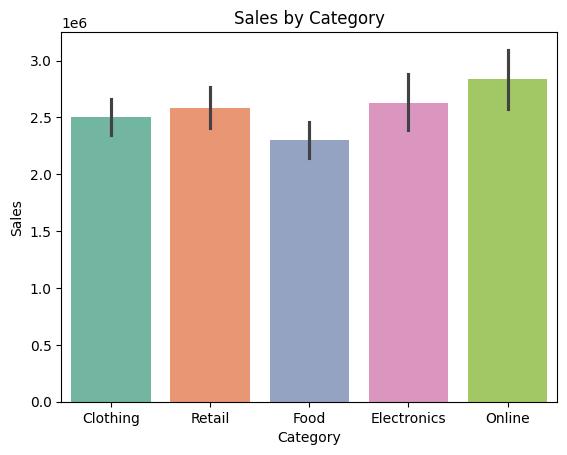

In [35]:
sns.barplot(x="category", y="sales", data=df,palette="Set2")
plt.title("Sales by Category")
plt.xlabel("Category")
plt.ylabel("Sales")
plt.show()

In [37]:
# Compute average sales per brand
brand_order = df.groupby("brand")["sales"].mean().sort_values(ascending=False).index
# Compute average purchase_amount per brand
avg_purchase_price_order = df.groupby("brand")["avg_purchase_price"].mean().sort_values(ascending=False).index

/tmp/ipython-input-2151626604.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="brand", y="sales", data=df, palette="Set2",order=brand_order)


<Axes: xlabel='brand', ylabel='sales'>

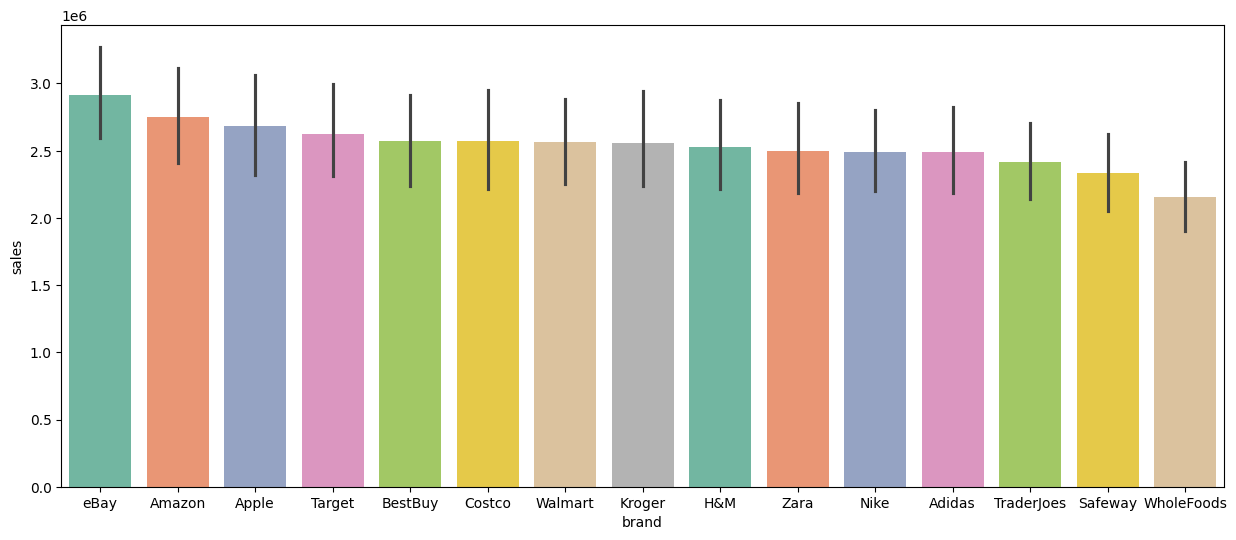

In [38]:
plt.figure(figsize=(15,6))
sns.barplot(x="brand", y="sales", data=df, palette="Set2",order=brand_order)

In [44]:
# === brand-month panel (aggregate banks) + driver fields ===
brand_mo = (df.groupby(["brand","date"], as_index=False)
              .agg(sales=("sales","sum"),
                   active=("unique_active_cardholders","sum"),
                   cardholders=("cardholders","sum"),
                   avg_purchase_price=("avg_purchase_price","mean"),
                   avg_trans=("avg_trans","mean"),
                   avg_spend_rate=("avg_spend_rate","mean")))
brand_mo["shop_rate"] = brand_mo["active"] / brand_mo["cardholders"]

In [45]:
# === correlations with sales (drivers) ===
corr = brand_mo[["sales","active","avg_purchase_price","avg_trans","shop_rate","avg_spend_rate"]]\
               .corr(numeric_only=True)
corr.style.background_gradient(cmap="coolwarm").format("{:.2f}")

,sales,active,avg_purchase_price,avg_trans,shop_rate,avg_spend_rate
sales,1.00,0.85,0.89,0.06,0.85,0.98
active,0.85,1.00,0.62,0.07,1.00,0.85
avg_purchase_price,0.89,0.62,1.00,0.06,0.62,0.90
avg_trans,0.06,0.07,0.06,1.00,0.07,0.06
shop_rate,0.85,1.00,0.62,0.07,1.00,0.85
avg_spend_rate,0.98,0.85,0.90,0.06,0.85,1.00


# Aamazon Sales Forecasting

In [106]:
#Creating a dataframe to filter amazon brand data from our dataset

amazon_df = df[df['brand']=="Amazon"].sort_values("date")

,date,brand,category,bank,cardholders,sales,unique_active_cardholders,transactions,shop_rate,avg_purchase_price,avg_trans,avg_spend_rate
52,2022-01-01,Amazon,Online,1,20000,992512.0,6040,22023,0.3020,164.32,3.65,49.6256
53,2022-01-01,Amazon,Online,2,15000,1595631.0,8411,34792,0.5607,189.71,4.14,106.3754
54,2022-01-01,Amazon,Online,3,10000,1714363.0,4301,16984,0.4301,398.60,3.95,171.4363
55,2022-01-01,Amazon,Online,4,7000,1289981.0,3941,8989,0.5630,327.32,2.28,184.2830
112,2022-02-01,Amazon,Online,1,20000,1201936.0,9010,39026,0.4505,133.40,4.33,60.0968


***Yearly Sales trend for Amazon***

In [55]:
#Creating,year,month and quarter columns
amazon_df['year']=amazon_df['date'].dt.year
amazon_df['month']=amazon_df['date'].dt.year
amazon_df["month"] = amazon_df["date"].dt.month
amazon_df["quarter"] = amazon_df["date"].dt.to_period("Q")


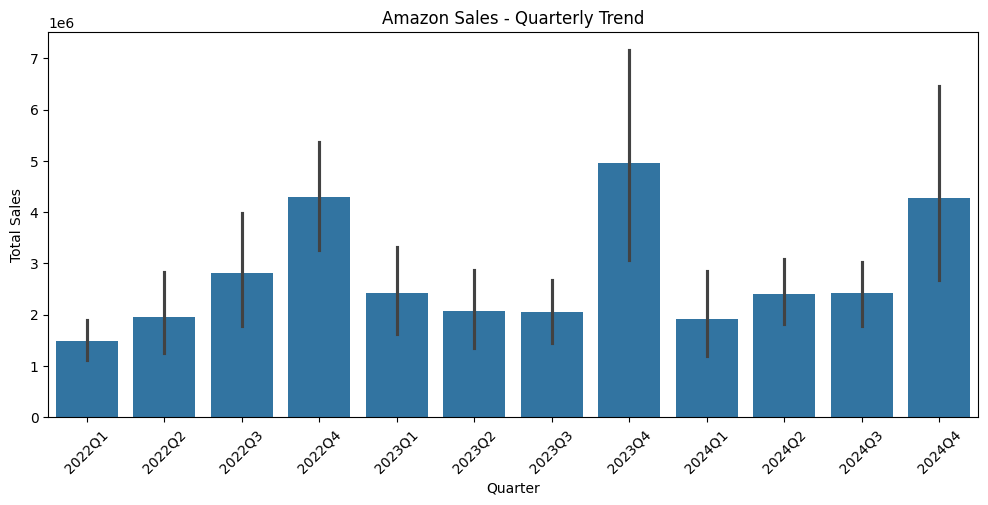

In [21]:
# Plot
plt.figure(figsize=(12,5))
sns.barplot(x="quarter", y="sales", data=amazon_df)
plt.title("Amazon Sales - Quarterly Trend")
plt.ylabel("Total Sales")
plt.xlabel("Quarter")
plt.xticks(rotation=45)
plt.show()

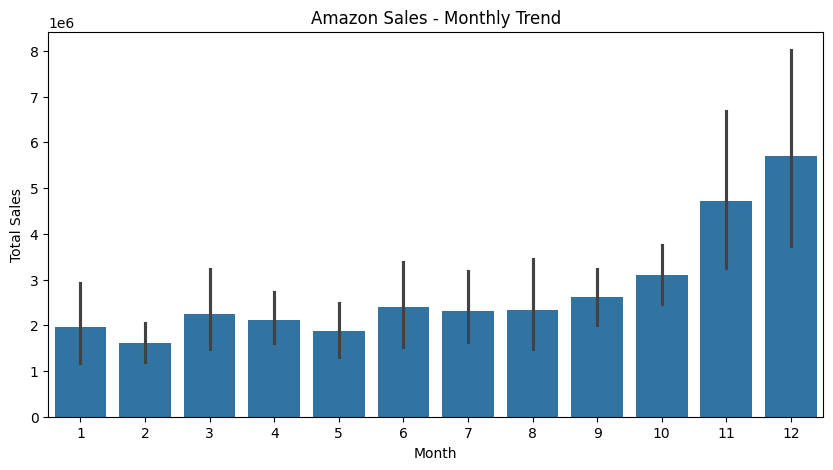

In [75]:
plt.figure(figsize=(10,5))
sns.barplot(x=amazon_df["month"], y="sales", data=amazon_df)
plt.title("Amazon Sales - Monthly Trend")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.show()

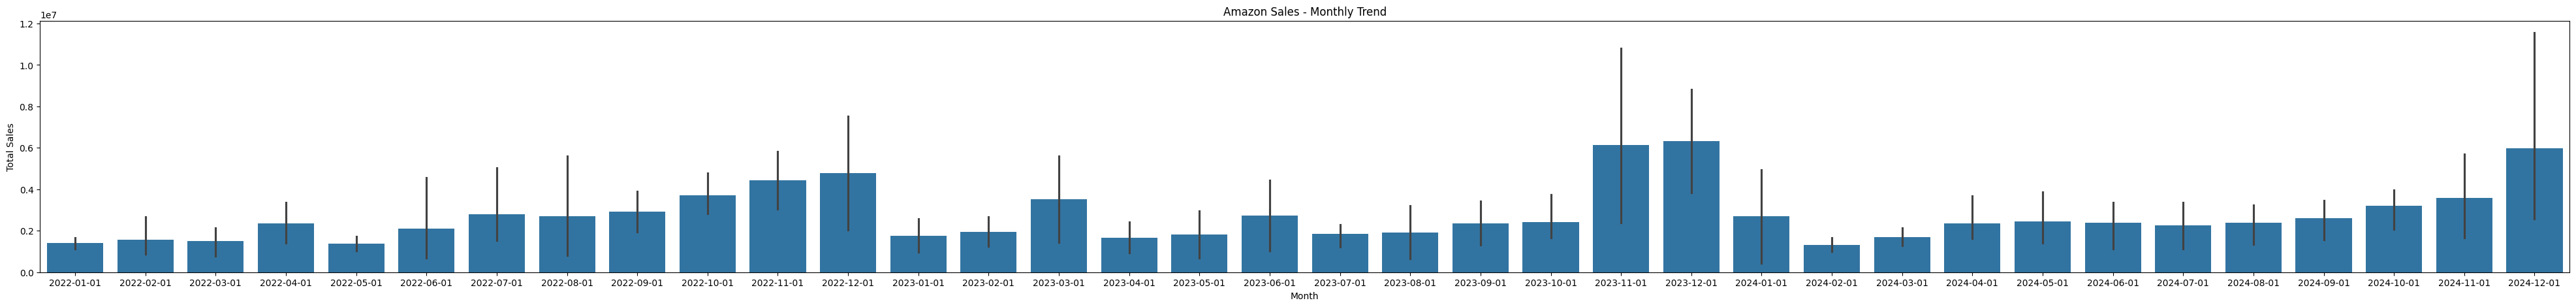

In [79]:
plt.figure(figsize=(50,5))
sns.barplot(x=amazon_df["date"], y="sales", data=amazon_df)
plt.title("Amazon Sales - Monthly Trend")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.show()

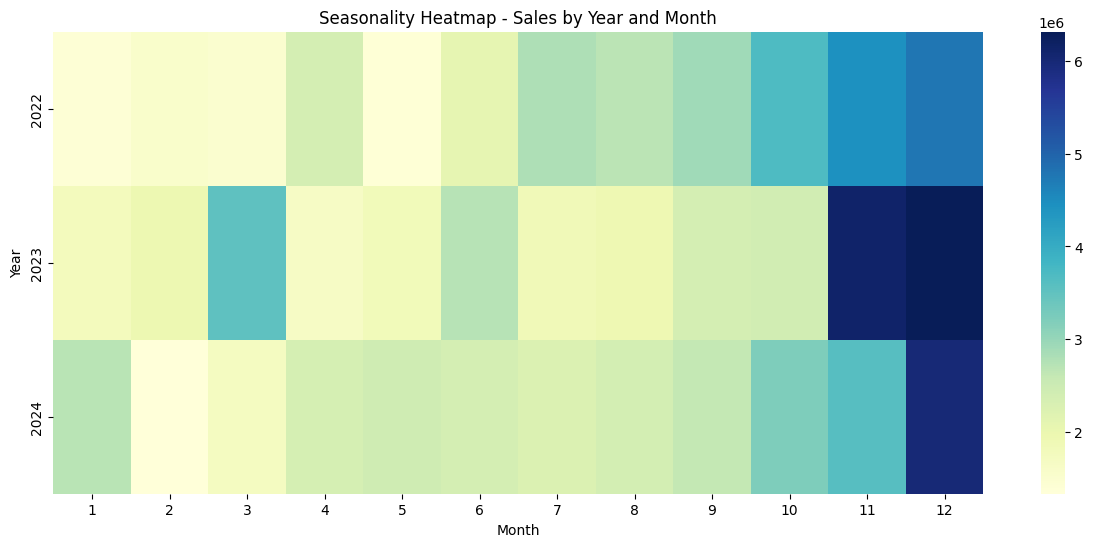

In [84]:
# Average monthly sales across banks for each year
heatmap_data = (amazon_df.groupby(["year","month"])["sales"].mean().unstack())

plt.figure(figsize=(15,6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, fmt=".0f")
plt.title("Seasonality Heatmap - Sales by Year and Month")
plt.ylabel("Year")
plt.xlabel("Month")
plt.show()

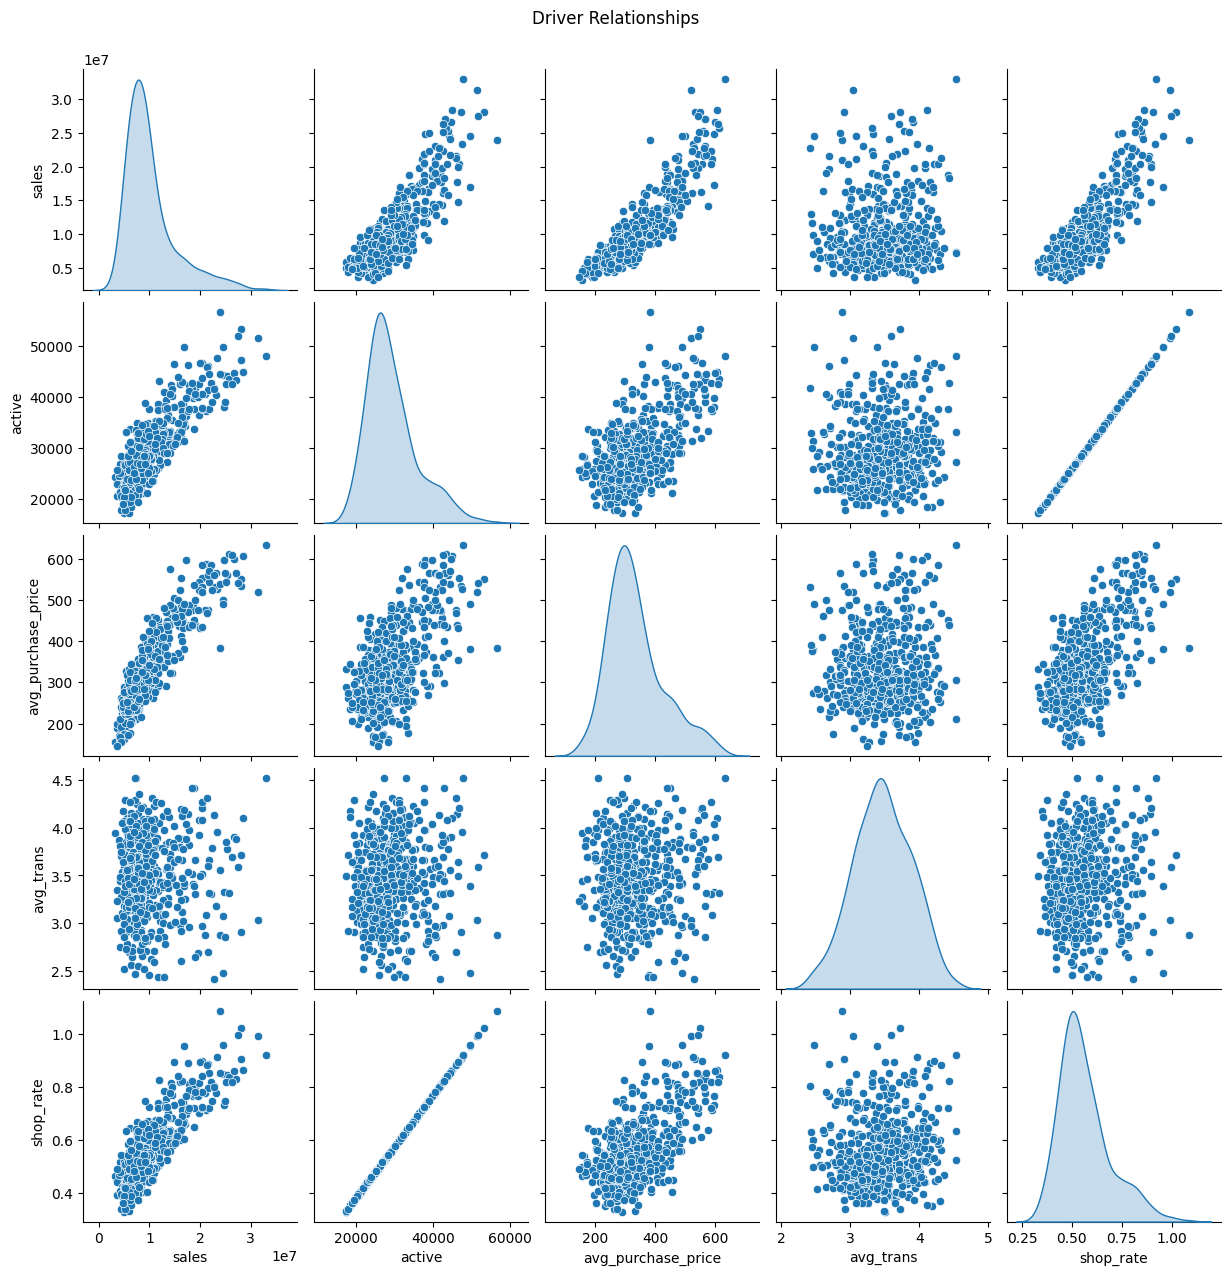

In [24]:
sns.pairplot(brand_mo[["sales","active","avg_purchase_price","avg_trans","shop_rate"]],
             diag_kind="kde")
plt.suptitle("Driver Relationships", y=1.02)
plt.show()

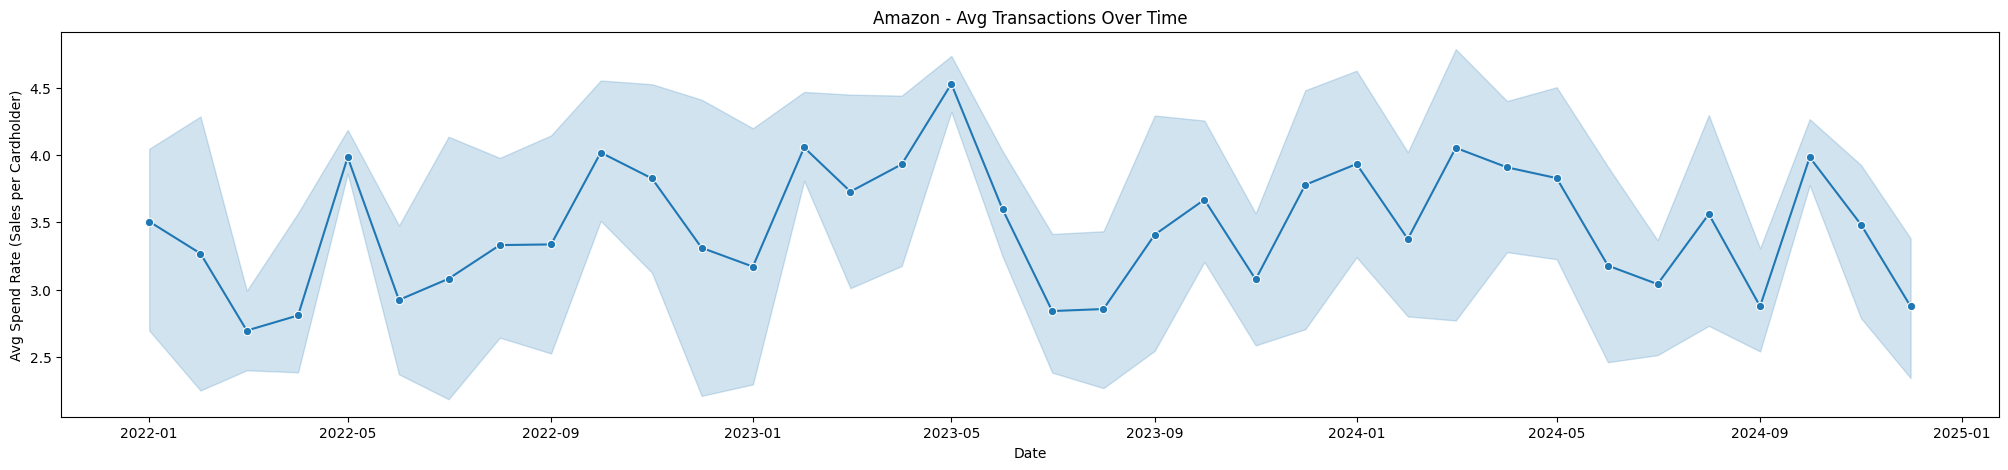

In [91]:
plt.figure(figsize=(25,5))
sns.lineplot(x="date", y="avg_trans", data=amazon_df,marker="o")
plt.title("Amazon - Avg Transactions Over Time")
plt.ylabel("Avg Spend Rate (Sales per Cardholder)")
plt.xlabel("Date")
plt.show()

***TIME SERIES FORECASTING***

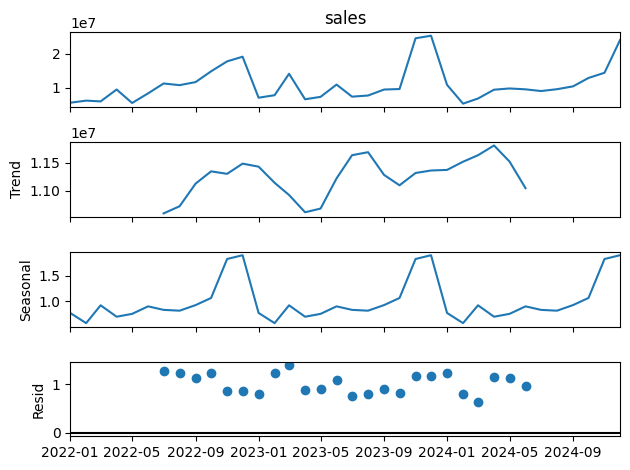

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aggregate monthly sales (e.g., Amazon)
amazon_monthly = (df[df["brand"]=="Amazon"]
                  .groupby("date")["sales"].sum()
                  .asfreq("MS")  # monthly start frequency
                  .interpolate())  # handle NaNs

# Decompose
decomp = seasonal_decompose(amazon_monthly, model="multiplicative", period=12)
decomp.plot()
plt.show()

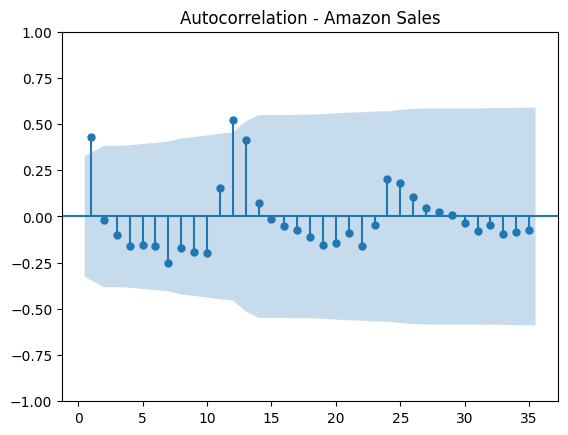

In [101]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(amazon_monthly.dropna(), lags=range(1, 36))
plt.title("Autocorrelation - Amazon Sales")
plt.show()

* Amazon sales show growth (trend) and repeated holiday-driven spikes (seasonality).
*	Any forecasting model must include seasonality (period=12 months), otherwise it will miss the holiday peaks. /n
* Holt-Winters (ETS) or SARIMA with seasonal terms are well-suited for this dataset italicized text

**SARIMA Model**

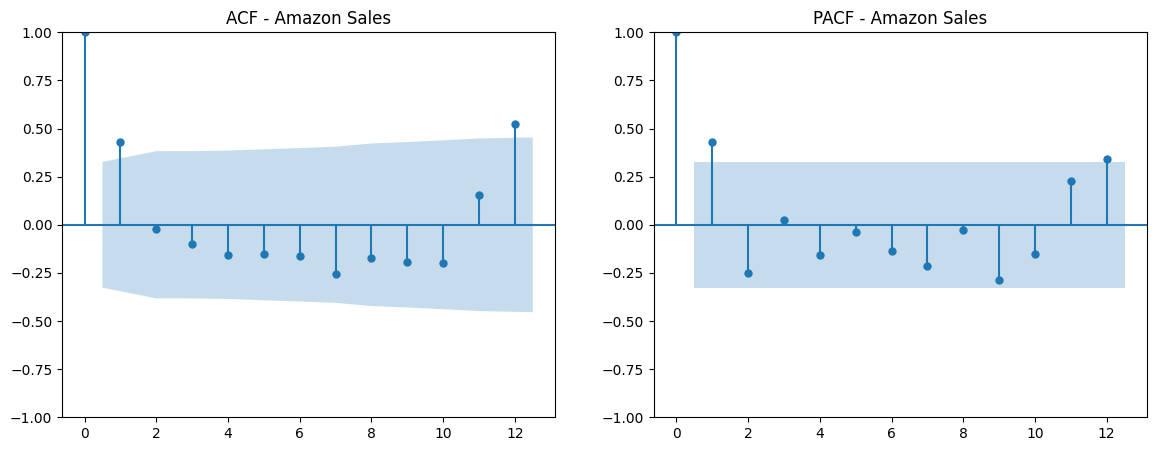

In [107]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Amazon monthly sales
amazon_monthly = (amazon_df
                  .groupby("date")["sales"].sum()
                  .asfreq("MS")
                  .interpolate())

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# ACF up to 36 lags
plot_acf(amazon_monthly.dropna(), lags=12, ax=axes[0])
axes[0].set_title("ACF - Amazon Sales")

# PACF up to 36 lags
plot_pacf(amazon_monthly.dropna(), lags=12, ax=axes[1], method="ywm")
axes[1].set_title("PACF - Amazon Sales")

plt.show()

In [111]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

#Grid search over small, practical ranges (works well for 3 years of data)
p = d = q = [0, 1, 2]
P = D = Q = [0, 1]
s = 12

def sarima_grid_search(series, pdq_grid, seasonal_grid, max_models=60):
    results = []
    tried = 0
    warnings.filterwarnings("ignore")

    for (p_, d_, q_) in pdq_grid:
        for (P_, D_, Q_) in seasonal_grid:
            if tried >= max_models:
                break
            try:
                model = SARIMAX(series,
                                order=(p_, d_, q_),
                                seasonal_order=(P_, D_, Q_, s),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                res = model.fit(disp=False)
                results.append({
                    "order": (p_, d_, q_),
                    "seasonal_order": (P_, D_, Q_, s),
                    "aic": res.aic
                })
                tried += 1
            except Exception:
                # skip combinations that fail to converge
                continue

    results_df = pd.DataFrame(results).sort_values("aic").reset_index(drop=True)
    return results_df

# Build parameter grids
pdq_grid = list(itertools.product(p, d, q))
seasonal_grid = list(itertools.product(P, D, Q))

# 3) Run search (kept small & fast)
grid_results = sarima_grid_search(amazon_monthly, pdq_grid, seasonal_grid, max_models=120)
grid_results.head(10)

,order,seasonal_order,aic
0,"(0, 2, 2)","(0, 1, 1, 12)",242.988727
1,"(0, 2, 2)","(1, 1, 1, 12)",244.823307
2,"(0, 1, 2)","(0, 1, 1, 12)",271.874081
3,"(1, 1, 2)","(0, 1, 1, 12)",272.775084
4,"(0, 1, 2)","(1, 1, 1, 12)",273.761228
5,"(0, 2, 1)","(0, 1, 1, 12)",274.725050
6,"(1, 1, 2)","(1, 1, 1, 12)",274.911638
7,"(0, 2, 1)","(1, 1, 1, 12)",277.430228
8,"(0, 0, 2)","(1, 1, 1, 12)",301.250925
9,"(1, 0, 2)","(0, 1, 1, 12)",301.513909


In [112]:
best = grid_results.iloc[0]
best_order = best["order"]
best_seasonal = best["seasonal_order"]
print("Best by AIC:", best_order, best_seasonal, "AIC:", round(best["aic"], 2))

best_model = SARIMAX(amazon_monthly,
                     order=best_order,
                     seasonal_order=best_seasonal,
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit(disp=False)

print(best_model.summary())

Best by AIC: (0, 2, 2) (0, 1, 1, 12) AIC: 242.99
                                      SARIMAX Results                                       
Dep. Variable:                                sales   No. Observations:                   36
Model:             SARIMAX(0, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -117.494
Date:                              Wed, 10 Sep 2025   AIC                            242.989
Time:                                      18:01:39   BIC                            242.772
Sample:                                  01-01-2022   HQIC                           240.315
                                       - 12-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9089      1.073     -1.779      

In [113]:
h = 3
fc = best_model.get_forecast(steps=h)
pred = fc.predicted_mean
ci = fc.conf_int(alpha=0.05)

fc_index = pd.date_range(amazon_monthly.index[-1] + pd.offsets.MonthBegin(1), periods=h, freq="MS")
forecast_df = pd.DataFrame({
    "date": fc_index,
    "brand": "Amazon",
    "forecast_sales": pred.values,
    "lower_95": ci.iloc[:, 0].values,
    "upper_95": ci.iloc[:, 1].values
})
forecast_df["forecast_sales"] = forecast_df["forecast_sales"].round(0).astype(int)
forecast_df["lower_95"] = forecast_df["lower_95"].clip(lower=0).round(0).astype(int)
forecast_df["upper_95"] = forecast_df["upper_95"].round(0).astype(int)

forecast_df

,date,brand,forecast_sales,lower_95,upper_95
0,2025-01-01,Amazon,15715108,1254860,30175357
1,2025-02-01,Amazon,16191993,1671895,30712092
2,2025-03-01,Amazon,19620657,4968417,34272898


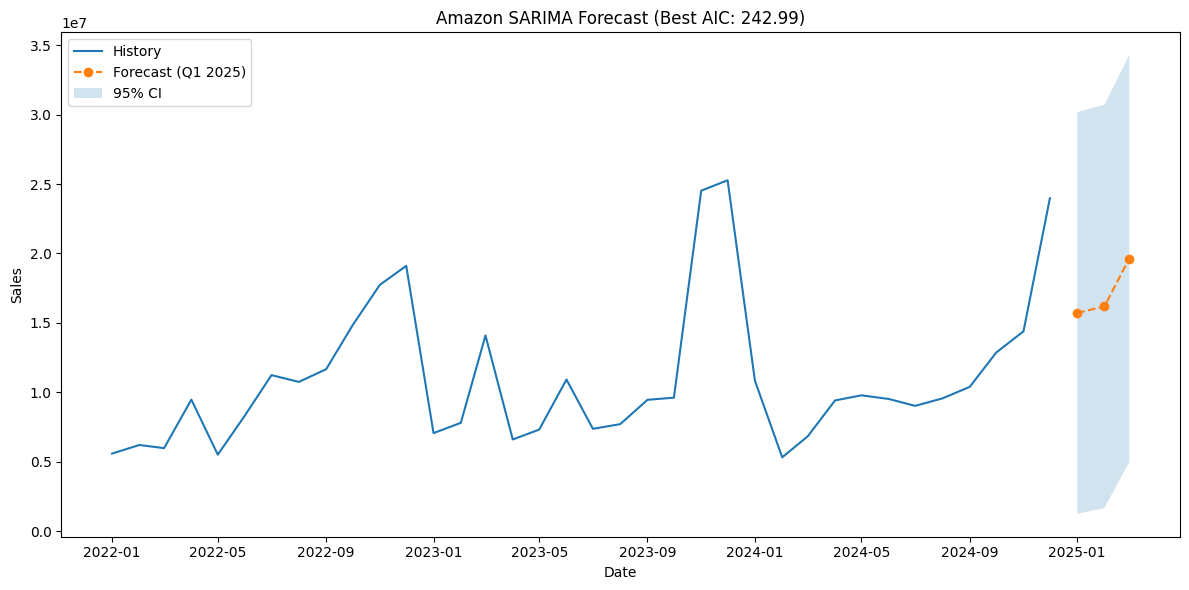

In [114]:
plt.figure(figsize=(12,6))
plt.plot(amazon_monthly.index, amazon_monthly.values, label="History")
plt.plot(forecast_df["date"], forecast_df["forecast_sales"], "--o", label="Forecast (Q1 2025)")
plt.fill_between(forecast_df["date"], forecast_df["lower_95"], forecast_df["upper_95"], alpha=0.2, label="95% CI")
plt.title(f"Amazon SARIMA Forecast (Best AIC: {round(best['aic'], 2)})")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout(); plt.show()